# Libraries

In [3]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [4]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import  ForecasterAutoregMultiOutput
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

In [5]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
catboost            1.0.3
lightgbm            3.3.1
matplotlib          3.4.3
numpy               1.19.5
pandas              1.3.0
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.1
-----
IPython             7.27.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.11
notebook            6.3.0
-----
Python 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Linux-5.11.0-43-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2022-01-02 13:32


# Data

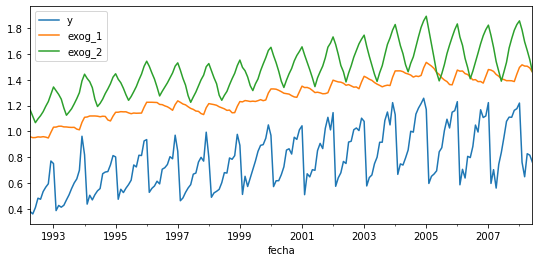

In [6]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# ForecasterAutoreg

In [7]:
steps = 65
n_backtest = 65 * 2
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-01-02 13:32:07 
Last fit date: None 
Skforecast version: 0.4.2 

## No exogenous variables

### Cross validation

In [8]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

data_train  = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=33, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.08286071 0.06515375]


pred
2000-05-01  0.589944
2000-06-01  0.611775
2000-07-01  0.654139

### Backtesting

In [9]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                              )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.07126209]


pred
1997-09-01  0.664121
1997-10-01  0.656080
1997-11-01  0.646774

In [10]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.09204162]


pred
1997-09-01  0.664121
1997-10-01  0.656080
1997-11-01  0.646774

In [11]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
data_train = data['y']
forecaster.fit(y=data_train)

last_window = data_train[:window_size]
predictions_1 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size:window_size + steps * 1]
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size + steps * 1: window_size + steps * 2]
predictions_3 = forecaster.predict(steps=60, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5
Number of observations used for backtesting: 190
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 60 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1992-09-01 00:00:00 -- 1998-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1998-02-01 00:00:00 -- 2003-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 2003-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.04517459]


pred
1992-09-01  0.611445
1992-10-01  0.690464
1992-11-01  0.745196

### Backtesting with prediction intervals

In [12]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict_interval(steps=steps, interval=[5, 95])

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.07126209]


pred  lower_bound  upper_bound
1997-09-01  0.664121     0.429100     0.805810
1997-10-01  0.656080     0.419175     0.830819
1997-11-01  0.646774     0.435779     0.844238

In [13]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict_interval(steps=steps, interval=[5, 95])

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.09204162]


pred  lower_bound  upper_bound
1997-09-01  0.664121     0.429100     0.805810
1997-10-01  0.656080     0.419175     0.830819
1997-11-01  0.646774     0.435779     0.844238

In [14]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
data_train = data['y']
forecaster.fit(y=data_train)

last_window = data_train[:window_size]
predictions_1 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95])

last_window = data_train[window_size:window_size + steps * 1]
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95])

last_window = data_train[window_size + steps * 1: window_size + steps * 2]
predictions_3 = forecaster.predict_interval(steps=60, last_window=last_window, interval=[5, 95])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5
Number of observations used for backtesting: 190
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 60 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1992-09-01 00:00:00 -- 1998-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1998-02-01 00:00:00 -- 2003-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 2003-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.04517459]


pred  lower_bound  upper_bound
1992-09-01  0.611445     0.250655     0.808251
1992-10-01  0.690464     0.316639     0.924920
1992-11-01  0.745196     0.402691     1.014314

### Grid search

In [15]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 65,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  8.68it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.05695977693220243



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.056960   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.057788   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.063423   1.00

In [16]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 65,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 9


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 12.61it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.07133997765339034



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.071340   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.072471   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.079972   1.00

## One exogenous variables

### Cross validation

In [17]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data['exog_1'],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.00725877 0.00515989]


pred
2000-05-01  0.626828
2000-06-01  0.719055
2000-07-01  0.816182

### Backtesting

In [18]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00859155]


pred
1997-09-01  0.733744
1997-10-01  0.818230
1997-11-01  0.773615

In [19]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, 'exog_1'])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0131768]


pred
1997-09-01  0.733744
1997-10-01  0.818230
1997-11-01  0.773615

In [20]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data['exog_1'])
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data['exog_1'])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0018237]


pred
1993-02-01  0.457061
1993-03-01  0.391733
1993-04-01  0.396465

### Backtesting with prediction intervals

In [21]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'], interval=[5, 95])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'], interval=[5, 95])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00859155]


pred  lower_bound  upper_bound
1997-09-01  0.733744     0.600824     0.822412
1997-10-01  0.818230     0.685024     0.913410
1997-11-01  0.773615     0.617641     0.878796

In [22]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, 'exog_1'])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95]
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0131768]


pred  lower_bound  upper_bound
1997-09-01  0.733744     0.600824     0.822412
1997-10-01  0.818230     0.685024     0.913410
1997-11-01  0.773615     0.617641     0.878796

In [23]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data['exog_1'])
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                                )
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data['exog_1'])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95]
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95]
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict_interval(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00



pred  lower_bound  upper_bound
1993-02-01  0.457061     0.369196     0.515796
1993-03-01  0.391733     0.317947     0.457602
1993-04-01  0.396465     0.308157     0.468159

### Grid search

In [24]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 11.98it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.006552005613686084



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.006552   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.048325   0.10
0                        [1, 2, 3]  {'alpha': 0.01}  0.052420   0.01
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.052659   1.00
1                        [1, 2, 3]   {'alpha': 0.1}  0.054075   0.10
2                        [1, 2, 3]     {'alpha': 1}  0.062784   1.00
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.064258   0.10
8                    [1, 2, 3, 20]     {'alpha': 1}  0.065326   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.065491   0.01

In [25]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 15.74it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.009313929773425255


lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.009314   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.052626   0.10
0                        [1, 2, 3]  {'alpha': 0.01}  0.055627   0.01
1                        [1, 2, 3]   {'alpha': 0.1}  0.058592   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.063593   1.00
2                        [1, 2, 3]     {'alpha': 1}  0.073676   1.00
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.077249   0.10
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.078523   0.01
8                    [1, 2, 3, 20]     {'alpha': 1}  0.080274   1.00

## Multiple exogenous variables

### Cross validation

In [26]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.00172239 0.00118319]


pred
2000-05-01  0.651386
2000-06-01  0.729994
2000-07-01  0.842437

### Backtesting

In [27]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00165938]


pred
1997-09-01  0.750430
1997-10-01  0.815434
1997-11-01  0.767007

In [28]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, ['exog_1', 'exog_2']])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0027606]


pred
1997-09-01  0.750430
1997-10-01  0.815434
1997-11-01  0.767007

In [29]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data[['exog_1', 'exog_2']])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00025246]


pred
1993-02-01  0.407039
1993-03-01  0.411560
1993-04-01  0.413280

### Backtesting with prediction intervals

In [30]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']], interval=[5, 95])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']], interval=[5, 95])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00165938]


pred  lower_bound  upper_bound
1997-09-01  0.750430     0.689112     0.789176
1997-10-01  0.815434     0.754384     0.873356
1997-11-01  0.767007     0.694019     0.822218

In [31]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, ['exog_1', 'exog_2']])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95]
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0027606]


pred  lower_bound  upper_bound
1997-09-01  0.750430     0.689112     0.789176
1997-10-01  0.815434     0.754384     0.873356
1997-11-01  0.767007     0.694019     0.822218

In [32]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    verbose    = True
                                )
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data[['exog_1', 'exog_2']])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95]
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95]
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict_interval(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00



pred  lower_bound  upper_bound
1993-02-01  0.407039     0.382071     0.423209
1993-03-01  0.411560     0.389522     0.435482
1993-04-01  0.413280     0.387611     0.434405

### Grid search

In [33]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  8.41it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.001540826373165715



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.001541   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.012537   0.10
1                        [1, 2, 3]   {'alpha': 0.1}  0.023995   0.10
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.025421   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.032706   1.00
2                        [1, 2, 3]     {'alpha': 1}  0.044056   1.00
0                        [1, 2, 3]  {'alpha': 0.01}  0.045540   0.01
8                    [1, 2, 3, 20]     {'alpha': 1}  0.047555   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.053880   0.01

In [34]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 10.50it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.002050880092725653



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.002051   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.013911   0.10
1                        [1, 2, 3]   {'alpha': 0.1}  0.024532   0.10
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.026141   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.039879   1.00
0                        [1, 2, 3]  {'alpha': 0.01}  0.040048   0.01
2                        [1, 2, 3]     {'alpha': 1}  0.050059   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.052993   0.01
8                    [1, 2, 3, 20]     {'alpha': 1}  0.056748   1.00

# ForecasterAutoregCustom

## No exogenous variables

In [35]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''

    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])

    return predictors

In [36]:
steps = 65
n_backtest = 65 * 2
forecaster = ForecasterAutoregCustom(
                regressor      = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )
forecaster

ForecasterAutoregCustom 
Regressor: Ridge() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-01-02 13:34:18 
Last fit date: None 
Skforecast version: 0.4.2 

### Cross validation

In [37]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

data_train  = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=33, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.07009799 0.03901877]


pred
2000-05-01  0.580386
2000-06-01  0.595468
2000-07-01  0.635986

### Backtesting

In [38]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.05211266]


pred
1997-09-01  0.734440
1997-10-01  0.759883
1997-11-01  0.735104

In [39]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.07705617]


pred
1997-09-01  0.734440
1997-10-01  0.759883
1997-11-01  0.735104

In [40]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
data_train = data['y']
forecaster.fit(y=data_train)

last_window = data_train[:window_size]
predictions_1 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size:window_size + steps * 1]
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size + steps * 1: window_size + steps * 2]
predictions_3 = forecaster.predict(steps=45, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.03103748]


pred
1993-12-01  0.666098
1994-01-01  0.655699
1994-02-01  0.637832

### Backtesting with prediction intervals

In [41]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict_interval(steps=steps, interval=[5, 95], n_boot=50)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95], n_boot=50)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.05211266]


pred  lower_bound  upper_bound
1997-09-01  0.734440     0.588096     0.992230
1997-10-01  0.759883     0.592025     0.878613
1997-11-01  0.735104     0.656411     0.968386

In [42]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict_interval(steps=steps, interval=[5, 95], n_boot=50)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95], n_boot=50)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.07705617]


pred  lower_bound  upper_bound
1997-09-01  0.734440     0.588096     0.992230
1997-10-01  0.759883     0.592025     0.878613
1997-11-01  0.735104     0.656411     0.968386

In [43]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
data_train = data['y']
forecaster.fit(y=data_train)

last_window = data_train[:window_size]
predictions_1 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95], n_boot=50)

last_window = data_train[window_size:window_size + steps * 1]
predictions_2 = forecaster.predict_interval(steps=steps, last_window=last_window, interval=[5, 95], n_boot=50)

last_window = data_train[window_size + steps * 1: window_size + steps * 2]
predictions_3 = forecaster.predict_interval(steps=45, last_window=last_window, interval=[5, 95], n_boot=50)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.03103748]


pred  lower_bound  upper_bound
1993-12-01  0.666098     0.568688     0.808417
1994-01-01  0.655699     0.444493     0.846309
1994-02-01  0.637832     0.392050     0.846333

### Grid search

In [44]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 0.052716606304486116



lags           params    metric  alpha
1  custom predictors   {'alpha': 0.1}  0.052717   0.10
0  custom predictors  {'alpha': 0.01}  0.054540   0.01
2  custom predictors     {'alpha': 1}  0.059633   1.00

In [45]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.057720439982460084



lags           params    metric  alpha
0  custom predictors  {'alpha': 0.01}  0.057720   0.01
1  custom predictors   {'alpha': 0.1}  0.067377   0.10
2  custom predictors     {'alpha': 1}  0.077891   1.00

## One exogenous variables

### Cross validation

In [46]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data['exog_1'],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.00673318 0.00483342]


pred
2000-05-01  0.597522
2000-06-01  0.695020
2000-07-01  0.809007

### Backtesting

In [47]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00706273]


pred
1997-09-01  0.774816
1997-10-01  0.857896
1997-11-01  0.795374

In [48]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, 'exog_1'])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01362473]


pred
1997-09-01  0.774816
1997-10-01  0.857896
1997-11-01  0.795374

In [49]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data['exog_1'])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data['exog_1'])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=45,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0019132]


pred
1993-12-01  0.883354
1994-01-01  0.850236
1994-02-01  0.541627

### Backtesting with prediction intervals

In [50]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'], interval=[5, 95], n_boot=50)

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'], interval=[5, 95], n_boot=50)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00706273]


pred  lower_bound  upper_bound
1997-09-01  0.774816     0.688838     0.917104
1997-10-01  0.857896     0.760687     0.944364
1997-11-01  0.795374     0.724459     0.946221

In [51]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, 'exog_1'])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95],
                    n_boot=50
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01362473]


pred  lower_bound  upper_bound
1997-09-01  0.774816     0.688838     0.917104
1997-10-01  0.857896     0.760687     0.944364
1997-11-01  0.795374     0.724459     0.946221

In [52]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data['exog_1'])
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                                )
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data['exog_1'])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict_interval(
                    steps=45,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1'],
                    interval=[5, 95],
                    n_boot=50
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00



pred  lower_bound  upper_bound
1993-12-01  0.883354     0.860051     0.914542
1994-01-01  0.850236     0.781072     0.888235
1994-02-01  0.541627     0.465683     0.602201

### Grid search

In [53]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.00609346138518794



lags           params    metric  alpha
0  custom predictors  {'alpha': 0.01}  0.006093   0.01
1  custom predictors   {'alpha': 0.1}  0.045024   0.10
2  custom predictors     {'alpha': 1}  0.055280   1.00

In [54]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.008866893051526192



lags           params    metric  alpha
0  custom predictors  {'alpha': 0.01}  0.008867   0.01
1  custom predictors   {'alpha': 0.1}  0.052756   0.10
2  custom predictors     {'alpha': 1}  0.070215   1.00

## Multiple exogenous variables

### Cross validation

In [55]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.0018747  0.00122174]


pred
2000-05-01  0.639804
2000-06-01  0.726863
2000-07-01  0.842420

### Backtesting

In [56]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.001999]


pred
1997-09-01  0.765493
1997-10-01  0.824864
1997-11-01  0.768290

In [57]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, ['exog_1', 'exog_2']])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00362354]


pred
1997-09-01  0.765493
1997-10-01  0.824864
1997-11-01  0.768290

In [58]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data[['exog_1', 'exog_2']])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=45,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00033138]


pred
1993-12-01  0.939969
1994-01-01  0.835890
1994-02-01  0.463705

### Backtesting with prediction intervals

In [59]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']], interval=[5, 95], n_boot=50)

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict_interval(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']], interval=[5, 95], n_boot=50)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2003-01-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.001999]


pred  lower_bound  upper_bound
1997-09-01  0.765493     0.718457     0.838162
1997-10-01  0.824864     0.766952     0.873652
1997-11-01  0.768290     0.718573     0.855744

In [60]:
# Backtest forecaster with initial train whithout refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, ['exog_1', 'exog_2']])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95],
                    n_boot=50
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 130
    Number of folds: 2
    Number of steps per fold: 65

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 1997-09-01 00:00:00 -- 2003-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1997-08-01 00:00:00
    Validation: 2003-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.00362354]


pred  lower_bound  upper_bound
1997-09-01  0.765493     0.718457     0.838162
1997-10-01  0.824864     0.766952     0.873652
1997-11-01  0.768290     0.718573     0.855744

In [61]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 50,
                                    verbose    = True
                                )
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data[['exog_1', 'exog_2']])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict_interval(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95],
                    n_boot=50
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict_interval(
                    steps=45,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']],
                    interval=[5, 95],
                    n_boot=50
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3])
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 45 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1993-12-01 00:00:00 -- 1999-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 1999-05-01 00:00:00 -- 2004-09-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-11-01 00:00:00
    Validation: 2004-10-01 00:00:00 -- 2008-06-01 00:00:00



pred  lower_bound  upper_bound
1993-12-01  0.939969     0.934281     0.949061
1994-01-01  0.835890     0.814925     0.847393
1994-02-01  0.463705     0.440602     0.485883

### Grid search

In [62]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.0016548261798387475



lags           params    metric  alpha
0  custom predictors  {'alpha': 0.01}  0.001655   0.01
1  custom predictors   {'alpha': 0.1}  0.013274   0.10
2  custom predictors     {'alpha': 1}  0.038349   1.00

In [63]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 10.92it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.0022121720220286793



lags           params    metric  alpha
0  custom predictors  {'alpha': 0.01}  0.002212   0.01
1  custom predictors   {'alpha': 0.1}  0.015404   0.10
2  custom predictors     {'alpha': 1}  0.049820   1.00

# ForecasterAutoregMultiOutput

## No exogenous variables

In [64]:
steps = 65
n_backtest = 35 * 2
regressor = Ridge()

forecaster = ForecasterAutoregMultiOutput(
                regressor = regressor,
                steps     = steps,
                lags      = 5 
             )
forecaster

ForecasterAutoregMultiOutput 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Maximum steps predicted: 65 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-01-02 13:34:37 
Last fit date: None 
Skforecast version: 0.4.2 

### Cross validation

In [65]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

data_train  = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=33, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.06592841 0.07277206]


pred
2000-05-01  0.539239
2000-06-01  0.525117
2000-07-01  0.509175

### Backtesting

In [66]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_2 = forecaster.predict(steps=5, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2008-01-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.09946174]


pred
2002-09-01  0.729894
2002-10-01  0.657388
2002-11-01  0.612306

In [67]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

data_train = data['y'].iloc[:initial_train_size + 0 * steps]
last_window = data_train[-window_size:]
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)

data_train = data['y'].iloc[:initial_train_size + 1 * steps]
last_window = data_train[-window_size:]
predictions_2 = forecaster.predict(steps=5, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.10186248]


pred
2002-09-01  0.729894
2002-10-01  0.657388
2002-11-01  0.612306

In [68]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
data_train = data['y']
forecaster.fit(y=data_train)

last_window = data_train[:window_size]
predictions_1 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size:window_size + steps * 1]
predictions_2 = forecaster.predict(steps=steps, last_window=last_window)

last_window = data_train[window_size + steps * 1: window_size + steps * 2]
predictions_3 = forecaster.predict(steps=60, last_window=last_window)

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5
Number of observations used for backtesting: 190
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 60 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1992-09-01 00:00:00 -- 1998-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 1998-02-01 00:00:00 -- 2003-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1992-08-01 00:00:00
    Validation: 2003-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.03361789]


pred
1992-09-01  0.609272
1992-10-01  0.680961
1992-11-01  0.716546

### Grid search

In [69]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}
# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = True,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.02660950335114411



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.026610   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.027233   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.037282   1.00

In [70]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}
# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  3.04it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.03962583157003535



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.039626   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.040668   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.057633   1.00

## One exogenous variables

### Cross validation

In [71]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data['exog_1'],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.04163288 0.00458755]


pred
2000-05-01  0.538135
2000-06-01  0.651384
2000-07-01  0.723189

### Backtesting

In [72]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, 'exog_1'])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, 'exog_1'])
predictions_2 = forecaster.predict(steps=5, exog=data.loc[idx_exog_predict, 'exog_1'])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2008-01-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0141912]


pred
2002-09-01  0.906343
2002-10-01  1.087925
2002-11-01  1.016271

In [73]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, 'exog_1'])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=5,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01531775]


pred
2002-09-01  0.906343
2002-10-01  1.087925
2002-11-01  1.016271

In [74]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data['exog_1'])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data['exog_1'])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, 'exog_1']
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01259432]


pred
1993-02-01  0.485122
1993-03-01  0.399091
1993-04-01  0.401692

### Grid search

In [75]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}
# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 0.026458945847696952



lags           params    metric  alpha
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.026459   0.10
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.029158   0.01
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.037014   1.00
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.066539   0.10
8                    [1, 2, 3, 20]     {'alpha': 1}  0.068411   1.00
1                        [1, 2, 3]   {'alpha': 0.1}  0.070501   0.10
0                        [1, 2, 3]  {'alpha': 0.01}  0.075991   0.01
2                        [1, 2, 3]     {'alpha': 1}  0.076690   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.090220   0.01

In [76]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}
# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 0.03964647627436689



lags           params    metric  alpha
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.039646   0.10
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.041312   0.01
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.057558   1.00
0                        [1, 2, 3]  {'alpha': 0.01}  0.083681   0.01
8                    [1, 2, 3, 20]     {'alpha': 1}  0.086005   1.00
1                        [1, 2, 3]   {'alpha': 0.1}  0.090119   0.10
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.092762   0.10
2                        [1, 2, 3]     {'alpha': 1}  0.095647   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.123659   0.01

## Multiple exogenous variables

### Cross validation

In [77]:
# Cross-validation forecaster
# ==============================================================================
metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = steps,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
display(predictions_cv.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = int(len(data)*0.5)

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 2 * steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=33, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_cv,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Number of folds: 2
Since `allow_incomplete_fold=True`, last fold only includes 33 observations instead of 65.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.
Error de backtest: [0.02789073 0.00463186]


pred
2000-05-01  0.553825
2000-06-01  0.622409
2000-07-01  0.713924

### Backtesting

In [78]:
# Backtest forecaster with initial train and refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
initial_train_size = len(data) - n_backtest

idx_data_train = data.iloc[:initial_train_size + 0 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 0 * steps:initial_train_size + 0 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(steps=steps, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

idx_data_train = data.iloc[:initial_train_size + 1 * steps].index
idx_exog_predict = data.iloc[initial_train_size + 1 * steps:initial_train_size + 1 * steps + steps].index
forecaster.fit(y=data.loc[idx_data_train, 'y'], exog=data.loc[idx_data_train, ['exog_1', 'exog_2']])
predictions_2 = forecaster.predict(steps=5, exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']])

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2008-01-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01390857]


pred
2002-09-01  0.913054
2002-10-01  1.026649
2002-11-01  1.007265

In [79]:
# Backtest forecaster with initial train without refit
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest
idx_train = data.iloc[:initial_train_size, :].index
forecaster.fit(y=data.loc[idx_train, 'y'], exog = data.loc[idx_train, ['exog_1', 'exog_2']])

idx_exog_predict = data.iloc[initial_train_size:initial_train_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window = data.iloc[initial_train_size:initial_train_size + steps, :].index
idx_exog_predict = data.iloc[initial_train_size + 1*steps:initial_train_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=5,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 125
Number of observations used for backtesting: 70
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 5 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2002-09-01 00:00:00 -- 2008-01-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-08-01 00:00:00
    Validation: 2008-02-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.01478398]


pred
2002-09-01  0.913054
2002-10-01  1.026649
2002-11-01  1.007265

In [80]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
display(predictions_backtest.head(3))

# Comprobación manual
# ==============================================================================
window_size = forecaster.window_size
forecaster.fit(y=data['y'], exog=data[['exog_1', 'exog_2']])

idx_last_window  = data.iloc[:window_size].index
idx_exog_predict = data.iloc[window_size:window_size + 1*steps, :].index
predictions_1 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps:window_size + steps].index
idx_exog_predict = data.iloc[window_size + 1*steps:window_size + 2*steps, :].index
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

idx_last_window  = data.iloc[steps*2:window_size + steps*2].index
idx_exog_predict = data.iloc[window_size + 2*steps:window_size + 3*steps, :].index
predictions_3 = forecaster.predict(
                    steps=55,
                    last_window=data.loc[idx_last_window, 'y'],
                    exog=data.loc[idx_exog_predict, ['exog_1', 'exog_2']]
                )

# Comparación predicciones
pd.testing.assert_frame_equal(
    predictions_backtest,
    pd.concat([predictions_1, predictions_2, predictions_3]).to_frame()
)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10
Number of observations used for backtesting: 185
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 55 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1993-02-01 00:00:00 -- 1998-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 1998-07-01 00:00:00 -- 2003-11-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1993-01-01 00:00:00
    Validation: 2003-12-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: [0.0085892]


pred
1993-02-01  0.535274
1993-03-01  0.427452
1993-04-01  0.406028

### Grid search

In [81]:
# Grid search hiperparameters and lags with model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [19]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 3


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.024076919981568273



lags           params  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  {'alpha': 0.01}   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   {'alpha': 0.1}   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...     {'alpha': 1}   

     metric  alpha  
0  0.024077   0.01  
1  0.024520   0.10  
2  0.035512   1.00

In [82]:
# Grid search hiperparameters and lags without model refit
# ==============================================================================
# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.023245540493208205



lags           params    metric  alpha
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'alpha': 0.01}  0.023246   0.01
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'alpha': 0.1}  0.029706   0.10
1                        [1, 2, 3]   {'alpha': 0.1}  0.050734   0.10
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]     {'alpha': 1}  0.052022   1.00
6                    [1, 2, 3, 20]  {'alpha': 0.01}  0.052180   0.01
0                        [1, 2, 3]  {'alpha': 0.01}  0.052866   0.01
7                    [1, 2, 3, 20]   {'alpha': 0.1}  0.064473   0.10
8                    [1, 2, 3, 20]     {'alpha': 1}  0.080210   1.00
2                        [1, 2, 3]     {'alpha': 1}  0.080500   1.00

In [83]:
print("TODAS LAS CELDAS EJECUTADAS SIN ERRORES")

TODAS LAS CELDAS EJECUTADAS SIN ERRORES
